In [1]:
import os
import torch
torch.cuda.set_device(1)
from video_dataset import image_data
from models import Attentive_VGG
import numpy as np
import torch.nn.utils as utils
import json
import argparse
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.misc import imread, imresize
from torchvision.transforms import ToPILImage
from PIL import Image

is_cuda = torch.cuda.is_available()
base_path = '/export/livia/Database/AFEW/Faces'

In [2]:
exp = {
    "paper_master":{
    "base_lr": 1e-2, "lrs": [10, 1], "wd": 5e-4, "seeds": [0], "opt": "sgd", "cuda": 5, "shift": False, 
    "eval_fact": 40, "net": "vgg16", "pooling":"softmax", "attention_hop":2, "dropout": 0, "ep": 30,
    "comment" : "with attention",
    "status": "Done 48.8"
    },
    "paper_master_att_1":{
        "base_lr": 1e-2, "lrs": [10, 1], "wd": 5e-4, "seeds": [0], "opt": "sgd", "cuda": 5, "shift": False, 
        "eval_fact": 40, "net": "vgg16", "pooling":"softmax", "attention_hop":2, "dropout": 0, "ep": 30,
        "comment" : "with attention at the end",
        "status": "??"
        },
}
name = "paper_master_att_1"

In [3]:
model = Attentive_VGG(num_classes=7, shift=exp[name]['shift'],
                      weights=os.path.join(base_path, 'models', 'pretrained'), net=exp[name]['net'],
                    pooling=exp[name]['pooling'], attention_hop=exp[name]['attention_hop'],
                    dropout=exp[name]['dropout'])


model.load_state_dict(torch.load(os.path.join(base_path, 'models', 'paper', name + '.pth')))

if is_cuda:
    model.cuda()

model.eval()
_, valid_loader = image_data(path=base_path, num_frames_per_clip=16,
                    bs=3, debug=False, 
                    size=224, num_workers=8, eval_fact=exp[name]['eval_fact'])

idx2class = {k:v for k,v in enumerate(valid_loader.dataset.classes)}

vgg16_att_hop_2_False_softmax


In [4]:
oo, ss, tt, dd = [], [], [], []
with torch.no_grad():
    for data, target in valid_loader:
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        output, spatial, temporal = model(data)

        if target.item() == output.argmax(dim=-1).item():
            oo.append(output)
            ss.append(spatial)
            tt.append(temporal)
            dd.append(data)

# data = data.squeeze().cpu()
# temporal = temporal.squeeze().cpu().numpy()
# spatial_all = spatial.mean(1)
# spatial_all = spatial_all.cpu().numpy()
# spatial_all = spatial_all.reshape(spatial_all.shape[0], 7, 7)
# spatial = spatial.cpu().numpy()
# spatial = spatial.reshape(spatial.shape[0], spatial.shape[1], 7, 7)
# cls = target.item()
# print(target, output.argmax(dim=-1))

In [5]:
num_frames = 3
scale = 48

In [14]:
def show_graph(idx):
    data = dd[idx].squeeze().cpu()
    temporal = tt[idx].squeeze().cpu().numpy()
    spatial_all = ss[idx].mean(1)
    spatial_all = spatial_all.cpu().numpy()
    spatial_all = spatial_all.reshape(spatial_all.shape[0], 7, 7)
    spatial = ss[idx].cpu().numpy()
    spatial = spatial.reshape(spatial.shape[0], spatial.shape[1], 7, 7)
    cls = oo[idx].argmax(dim=-1).item()
    
    print(np.argsort(temporal[:,cls])[-num_frames:])
    print(np.argmax(temporal[:,cls]))
    print(valid_loader.dataset.classes[cls])
    
    most_confidants = np.argsort(temporal[:,cls])[-num_frames:]
#     most_confidants.sort()
    less_confidants = np.argsort(temporal[:,cls])[:num_frames]
    most_confidants = np.concatenate([most_confidants, less_confidants])
    most_confidants.sort()
    
    print(most_confidants)
    length = len(most_confidants) 
    
    sm = sum(temporal[:,cls])
    print(temporal[:,cls]/sm)
    
    
    plt.figure(figsize=(16, 8))
    # salients = temporal.sum(axis=1)
    # maxx = temporal[frames].max(1).max(0)

    # for idx, t in enumerate(frames, 1):

    #     plt.subplot(np.ceil(len(frames) / 10.)*4, 10, idx)

    #     bars = plt.barh(0, salients[t]*10)
    #     bars[0].set_facecolor('g')
    #     plt.xlim(0, 1)  
    #     plt.ylim(0, 1.5) 
    #     plt.axis('off')

    for idx, t in enumerate(most_confidants, 1):
        image = ToPILImage()(data[t])
        image = image.resize([7 * scale, 7 * scale], Image.LANCZOS)

        plt.subplot(np.ceil(length / num_frames)*3, num_frames, idx + 0*length)    
        plt.imshow(image, aspect='auto')
    #     plt.imshow(image)

        plt.axis('off')

    for idx, t in enumerate(most_confidants, 1):

        image = ToPILImage()(data[t])
        image = image.resize([7 * scale, 7 * scale], Image.LANCZOS)

        plt.subplot(np.ceil(length / num_frames)*3, num_frames, idx + 1*length)
        plt.text(0, 1, f'{t}', color='black', backgroundcolor='white', fontsize=8)

        plt.imshow(image, aspect='auto')
    #     plt.imshow(image)

        current_alpha = spatial_all[t, :,:]
    #     current_alpha = spatial[t, 0, :,:]
        alpha = skimage.transform.pyramid_expand(current_alpha, upscale=scale, sigma=8)
        plt.imshow(alpha, alpha=0.8, aspect='auto', cmap='hot')
    #     plt.imshow(alpha, alpha=0.4, cmap='gray')


        plt.axis('off')

    # for idx, t in enumerate(most_confidants, 1):

    #     image = ToPILImage()(data[t])
    #     image = image.resize([7 * scale, 7 * scale], Image.LANCZOS)

    #     plt.subplot(np.ceil(length / num_frames)*3, num_frames, idx + 2*length)
    #     plt.text(0, 1, f'{t}', color='black', backgroundcolor='white', fontsize=8)

    #     plt.imshow(image, aspect='auto')
    # #     plt.imshow(image)

    # #     current_alpha = spatial_all[t, :,:]
    #     current_alpha = spatial[t, 1, :,:]
    #     alpha = skimage.transform.pyramid_expand(current_alpha, upscale=scale, sigma=8)
    #     plt.imshow(alpha, alpha=0.8, aspect='auto', cmap='hot')
    # #     plt.imshow(alpha, alpha=0.4, cmap='gray')


    #     plt.axis('off')

    # for idx, t in enumerate(frames, 1):

    #     plt.subplot(np.ceil(len(frames) / 10.)*4, 10, idx + len(frames)*3)
    #     maxx = temporal[frames].max(1).max(0)
    #     cls = temporal[t].argmax(axis=-1)
    #     x = np.arange(7)
    #     bars = plt.bar(x, temporal[t])
    #     bars[cls].set_facecolor('r')
    #     plt.xticks(x, valid_loader.dataset.classes, rotation='vertical')
    #     plt.ylim(0, maxx) 

    #     ax = plt.gca()
    #     ax.get_yaxis().set_visible(False)
    #     ax.get_xticklabels()[cls].set_color('red') 

    for idx, t in enumerate(most_confidants, 1):

        plt.subplot(np.ceil(length / num_frames)*3, num_frames, idx + 2*length)
        x = np.arange(7)
        max_temp = np.argmax(temporal[t])
        bars = plt.barh(x, temporal[t])
        bars[max_temp].set_facecolor('r')
        if idx == 1:
            plt.yticks(x, valid_loader.dataset.classes)

    #     plt.xlim(0, maxx) 
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yticklabels()[cls].set_color('red')
        if idx > 1:
            ax.get_yaxis().set_visible(False)


    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
    base = 2
    arr = np.log2(temporal[most_confidants, :] + 1) / np.log(base)
    arr[:, cls]
    plt.figure(figsize=(8, 4))

    plt.plot(list(range(num_frames)), arr[:,cls])
    plt.xticks(list(range(num_frames)), most_confidants)
    plt.yticks([])
    plt.xlabel('Frames')
    plt.ylabel('Attention weight')

#     plt.subplot(1, 2, 2)
#     bars = plt.bar(np.arange(7), temporal.sum(0))
#     bars[cls].set_facecolor('r')
#     plt.xticks(np.arange(7), valid_loader.dataset.classes)
#     ax = plt.gca()
#     ax.get_xticklabels()[cls].set_color('red') 
#     plt.show()

    
    plt.show()

[ 7  9  6 36 37 38]
38
Sad
[ 6  7  9 24 25 26 36 37 38 46 47 48]
[0.01561877 0.01561877 0.01576987 0.01880847 0.02246225 0.02215438
 0.02471268 0.02312489 0.02039581 0.02322379 0.01897021 0.01943495
 0.01762129 0.01713532 0.01954906 0.0200506  0.01983938 0.01916891
 0.01653904 0.01716373 0.0153627  0.0153257  0.01318002 0.01330632
 0.01066084 0.00999521 0.01182172 0.01403673 0.01499523 0.01441337
 0.01654162 0.01565624 0.01732122 0.01605025 0.01825543 0.01769853
 0.02526034 0.02752061 0.02978356 0.02199155 0.01699015 0.01683214
 0.01955319 0.020639   0.01762212 0.01493864 0.01121027 0.01225228
 0.01301551 0.01549417 0.01686781 0.01684197 0.01841385 0.01694473
 0.01611555 0.01576947 0.01395973]


/export/livia/home/vision/masih/miniconda3/envs/ml/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


IndexError: list index out of range

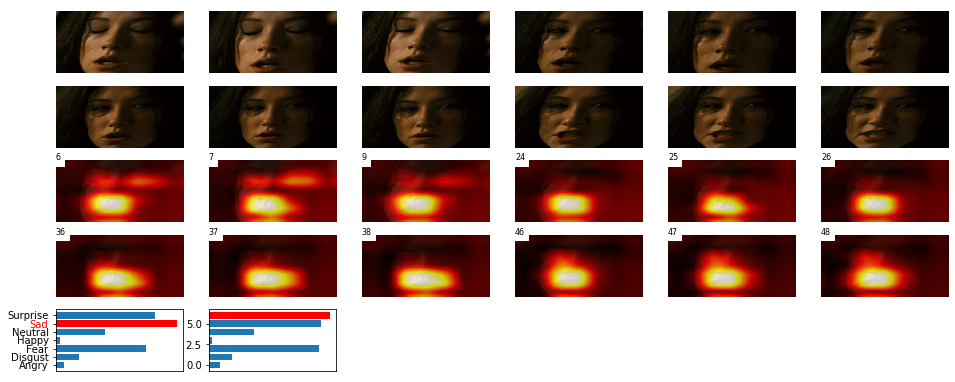

In [15]:
show_graph(139)